# Vision-RAG - Cohere Embed v4 🤝 Gemini Flash

RAG so far has been mostly done on text. For rich multimedia files like PDFs it often required complex OCR pre-processing steps and dropping relevant graphics from your RAG pipeline.

This notebook shows a pure **vision-based RAG** approach, that even works for complex infographics.

It consists of two components:

*   **Retrieval:** Here we use the state-of-the-art text & image retrieval model [Embed v4](https://cohere.com/blog/embed-4) by Cohere. It allows us to embed and search complex images, like infographics, without any pre-processing.
*   **Vision-LLM:** Here we use [Gemini Flash 2.5](https://deepmind.google/technologies/gemini/flash/) by Google. It allows images & text questions as inputs, and is able to answer questions based on it.




## Setup Cohere for Retrieval

Go to [cohere.com](https://cohere.com) and get an API key. Also install our SDK for easier usage and pdf2image and poppler to convert PDFs to images.

In [ ]:
!pip install -q cohere

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 21.8 MB/s eta 0:00:00


In [ ]:
# Create the Cohere API client. Get your API key from cohere.com
import cohere
cohere_api_key = "<<YOUR_COHERE_KEY>>" #Replace with your Cohere API key
co = cohere.ClientV2(api_key=cohere_api_key)

## Setup Gemini for Generation
Go to the [Google AI Studio](https://aistudio.google.com/apikey) and generate an API Key for Gemini. Gemini also offers a generous free-tier.

Then install the Google GenAI SDK.

In [ ]:
!pip install -q google-genai

In [ ]:
from google import genai
gemini_api_key = "<<YOUR_GEMINI_KEY>>"  #Replace with your Gemini API key
client = genai.Client(api_key=gemini_api_key)

In [ ]:
# Wrap long longs in this Notebook
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# Image Search

This section will load several infographics from [appeconomyinsights.com](https://www.appeconomyinsights.com/).

For each image we will call [Cohere Embed v4]((https://cohere.com/blog/embed-4) to get an embeddings. This embedding allows us later to perform search to find relevant images for our questions.

In [ ]:
import requests
import os
import io
import base64
import PIL
import tqdm
import time
import numpy as np

In [ ]:
# Some helper functions to resize images and to convert them to base64 format
max_pixels = 1568*1568  #Max resolution for images

# Resize too large images
def resize_image(pil_image):
    org_width, org_height = pil_image.size

    # Resize image if too large
    if org_width * org_height > max_pixels:
        scale_factor = (max_pixels / (org_width * org_height)) ** 0.5
        new_width = int(org_width * scale_factor)
        new_height = int(org_height * scale_factor)
        pil_image.thumbnail((new_width, new_height))

# Convert images to a base64 string before sending it to the API
def base64_from_image(img_path):
    pil_image = PIL.Image.open(img_path)
    img_format = pil_image.format if pil_image.format else "PNG"

    resize_image(pil_image)

    with io.BytesIO() as img_buffer:
        pil_image.save(img_buffer, format=img_format)
        img_buffer.seek(0)
        img_data = f"data:image/{img_format.lower()};base64,"+base64.b64encode(img_buffer.read()).decode("utf-8")

    return img_data



In [ ]:
# Several images from https://www.appeconomyinsights.com/
images = {
    "tesla.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fbef936e6-3efa-43b3-88d7-7ec620cdb33b_2744x1539.png",
    "netflix.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F23bd84c9-5b62-4526-b467-3088e27e4193_2744x1539.png",
    "nike.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fa5cd33ba-ae1a-42a8-a254-d85e690d9870_2741x1541.png",
    "google.png": "https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F395dd3b9-b38e-4d1f-91bc-d37b642ee920_2741x1541.png",
    "accenture.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F08b2227c-7dc8-49f7-b3c5-13cab5443ba6_2741x1541.png",
    "tecent.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F0ec8448c-c4d1-4aab-a8e9-2ddebe0c95fd_2741x1541.png"
}

In [ ]:
# Download the images and compute an embedding for each image
img_folder = "img"
os.makedirs(img_folder, exist_ok=True)

img_paths = []
doc_embeddings = []
for name, url in tqdm.tqdm(images.items()):
    img_path = os.path.join(img_folder, name)
    img_paths.append(img_path)

    # Download the image
    if not os.path.exists(img_path):
        response = requests.get(url)
        response.raise_for_status()

        with open(img_path, "wb") as fOut:
            fOut.write(response.content)

    # Get the base64 representation of the image
    api_input_document = {
        "content": [
            {"type": "image", "image": base64_from_image(img_path)},
        ]
    }

    # Call the Embed v4.0 model with the image information
    api_response = co.embed(
        model="embed-v4.0",
        input_type="search_document",
        embedding_types=["float"],
        inputs=[api_input_document],
    )

    # Append the embedding to our doc_embeddings list
    emb = np.asarray(api_response.embeddings.float[0])
    doc_embeddings.append(emb)

doc_embeddings = np.vstack(doc_embeddings)
print("\n\nEmbeddings shape:", doc_embeddings.shape)


100%|██████████| 6/6 [00:10<00:00,  1.72s/it]



Embeddings shape: (6, 1536)


## Vision-RAG

The following shows a simple pipeline for vision-based RAG.

1) We first perform search() - We compute the embedding for the question. We can then use that embedding to search through our prevousily embedded images to find the most relevant image. We return this image.

2) In answer(), we send the question + image to Gemini to give us a final answer to our question

In [ ]:
# Search allows us to find relevant images for a given question using Cohere Embed v4
def search(question, max_img_size=800):
    # Compute the embedding for the query
    api_response = co.embed(
        model="embed-v4.0",
        input_type="search_query",
        embedding_types=["float"],
        texts=[question],
    )

    query_emb = np.asarray(api_response.embeddings.float[0])

    # Compute cosine similarities
    cos_sim_scores = np.dot(query_emb, doc_embeddings.T)

    # Get the most relevant image
    top_idx = np.argmax(cos_sim_scores)

    # Show the images
    print("Question:", question)

    hit_img_path = img_paths[top_idx]

    print("Most relevant image:", hit_img_path)
    image = PIL.Image.open(hit_img_path)
    max_size = (max_img_size, max_img_size)  # Adjust the size as needed
    image.thumbnail(max_size)
    display(image)
    return hit_img_path

# Answer the question based on the information from the image
# Here we use Gemini 2.5 as powerful Vision-LLM
def answer(question, img_path):
    prompt = [f"""Answer the question based on the following image.
Don't use markdown.
Please provide enough context for your answer.

Question: {question}""", PIL.Image.open(img_path)]

    response = client.models.generate_content(
        model="gemini-2.5-flash-preview-04-17",
        contents=prompt
    )

    answer = response.text
    print("LLM Answer:", answer)

Question: What is the net profit for Nike?
Most relevant image: img/nike.png


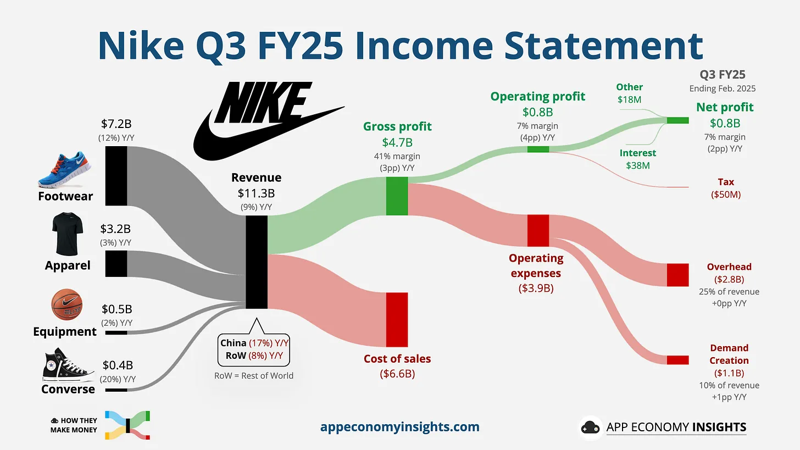

LLM Answer: According to the Nike Q3 FY25 Income Statement shown in the image, the Net profit for Nike is $0.8B.


In [ ]:
# Define the query
question = "What is the net profit for Nike?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

Question: What are the 3 largest acquisitions from Google?
Most relevant image: img/google.png


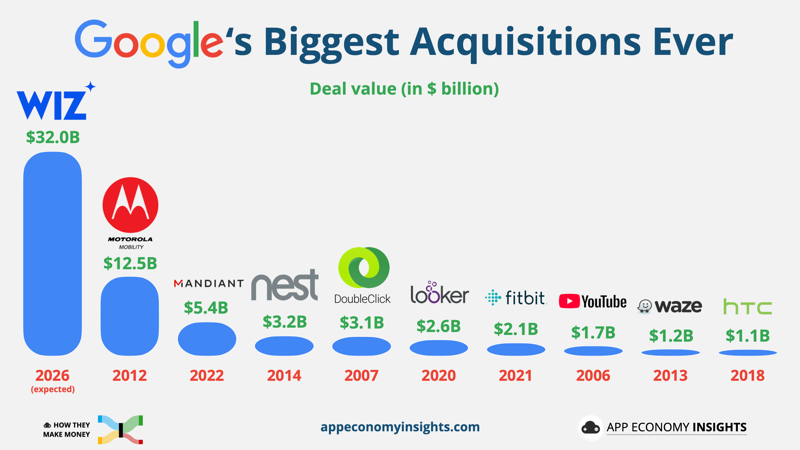

LLM Answer: Based on the image displaying Google's Biggest Acquisitions Ever, the three largest acquisitions are WIZ for $32.0B, Motorola Mobility for $12.5B, and Mandiant for $5.4B.


In [ ]:
# Define the query
question = "What are the 3 largest acquisitions from Google?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

Question: What would be the net profit of Tesla without interest?
Most relevant image: img/tesla.png


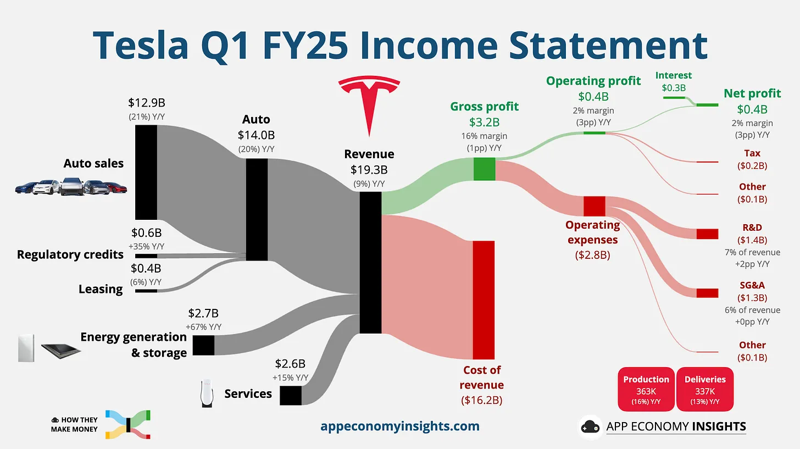

LLM Answer: Based on the Tesla Q1 FY25 Income Statement image provided, the reported Net profit is $0.4B. The diagram shows "Interest $0.3B" flowing in alongside Operating profit, Tax, and Other items to arrive at Net profit. This structure suggests the $0.3B represents Interest Income, which is added to operating profit before accounting for taxes and other items to reach net profit.

To find the net profit without this interest income, we subtract the interest income from the reported net profit:
Net profit without interest = Net profit - Interest
Net profit without interest = $0.4B - $0.3B = $0.1B.

Therefore, based on this diagram, the net profit of Tesla without the reported $0.3B interest income would be $0.1B.


In [ ]:
# Define the query
question = "What would be the net profit of Tesla without interest?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

Question: Is GenAI a good business for consulting companies?
Most relevant image: img/accenture.png


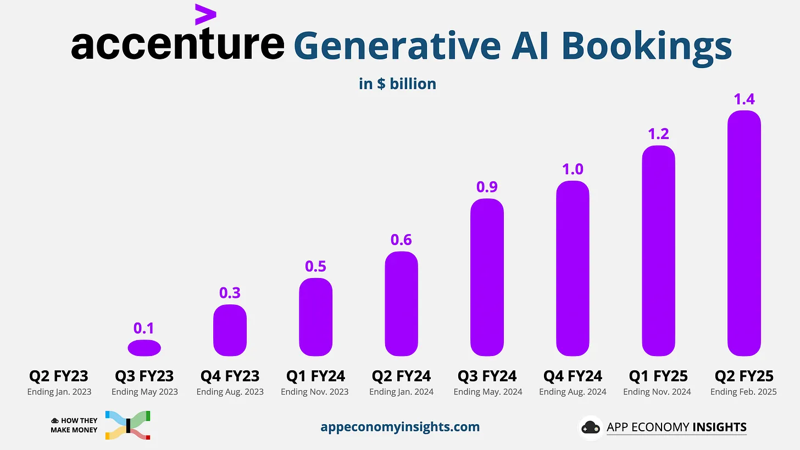

LLM Answer: Based on the image showing Accenture Generative AI Bookings, Generative AI appears to be a good business for this consulting company. The bar chart shows a significant and consistent increase in GenAI bookings over time. Starting at 0.1 billion in Q2 FY23, the bookings rise steadily through subsequent quarters, reaching 0.3 billion in Q3 FY23, 0.5 billion in Q4 FY23, 0.6 billion in Q1 FY24, 0.9 billion in Q2 FY24, 1.0 billion in Q3 FY24, 1.2 billion in Q4 FY24, and a projected 1.4 billion in Q1 FY25. This strong upward trend in bookings indicates growing demand and successful business in Generative AI services for Accenture.


In [ ]:
# Define the query
question = "Is GenAI a good business for consulting companies?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

Question: In which region does Netflix generate the highest revenue?
Most relevant image: img/netflix.png


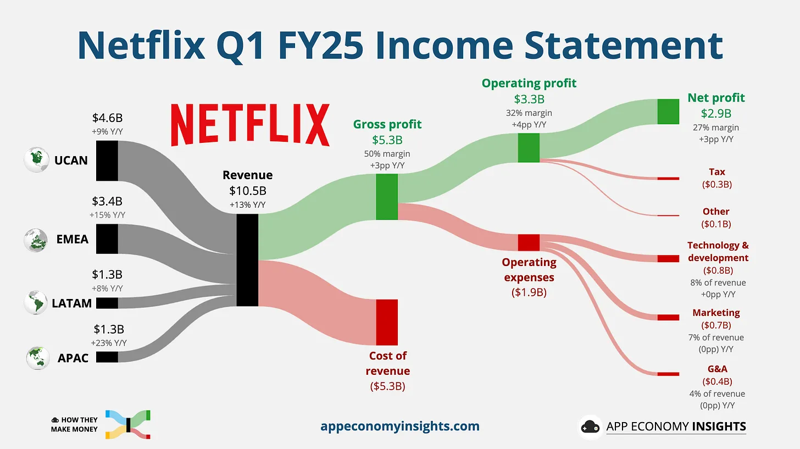

LLM Answer: Based on the Netflix Q1 FY25 Income Statement shown in the image, the UCAN region (United States and Canada) generates the highest revenue at $4.6 billion. This is higher than the revenue generated by EMEA ($3.4 billion), LATAM ($1.3 billion), and APAC ($1.3 billion).


In [ ]:
# Define the query
question = "In which region does Netflix generate the highest revenue?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

Question: How much could tecent grow their revenue year-over-year for the last 5 years?
Most relevant image: img/tecent.png


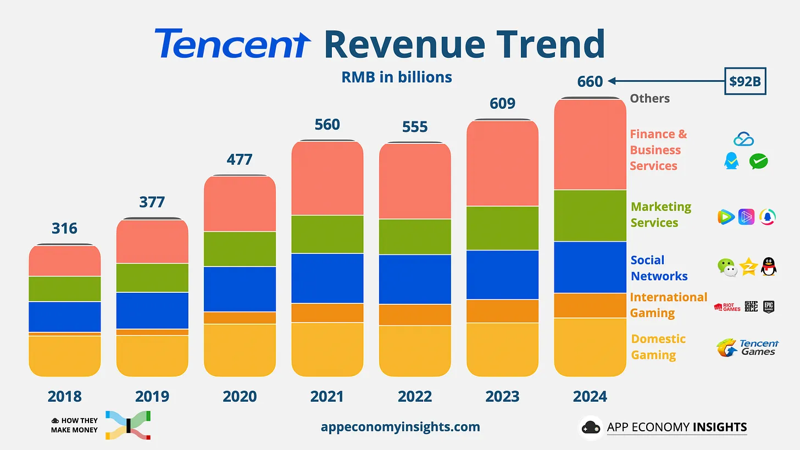

LLM Answer: Based on the provided image titled "Tencent Revenue Trend RMB in billions", we can calculate the year-over-year revenue growth for the last five years shown in the chart, which are 2020, 2021, 2022, 2023, and 2024. The revenue figures are:
2019: 377 billion RMB
2020: 477 billion RMB
2021: 560 billion RMB
2022: 555 billion RMB
2023: 609 billion RMB
2024: 660 billion RMB

Here is the year-over-year growth for each of those years compared to the previous year:
Growth in 2020 (vs 2019): ((477 - 377) / 377) * 100% = (100 / 377) * 100% ≈ 26.5%
Growth in 2021 (vs 2020): ((560 - 477) / 477) * 100% = (83 / 477) * 100% ≈ 17.4%
Growth in 2022 (vs 2021): ((555 - 560) / 560) * 100% = (-5 / 560) * 100% ≈ -0.9% (a decrease)
Growth in 2023 (vs 2022): ((609 - 555) / 555) * 100% = (54 / 555) * 100% ≈ 9.7%
Growth in 2024 (vs 2023): ((660 - 609) / 609) * 100% = (51 / 609) * 100% ≈ 8.4%

So, for the last five years shown (2020-2024), Tencent's year-over-year revenue growth rates were approximat

In [ ]:
# Define the query
question = "How much could tecent grow their revenue year-over-year for the last 5 years?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)